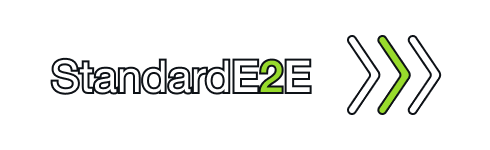

In [1]:
from IPython import display
display.Image("../assets/standard_e2e_logo_contrast.png", width=400)

## Frames and features for single dataset example

In this basic example we will cover the key concepts of StandardE2E library:
* How to prepare dataset for work with StandardE2E
* Logic behind preprocessing
* Adapters
* Index
* Utilizing Modalities
* Frame fetching in Dataset

## Preprocessing
First, in order to use a dataset with StandardE2E it is necessary to convert it to a unified format that would allow for consistent processing across different dataset, efficient sampling and training. In this introductory notebook we will focus on the `Waymo End-to-end` dataset only and will mostly cover library's concepts.

Basically, the preprocessing stage creates a separate `{segment_id}_{frame_id}.npz` file for each scene that contains its complete data. Together with `.npz` files it also outputs the `index.parquet` file that is used for rapid indexing / filtering / sampling of scenes and may also contain arbitrary additional (yet better compact) info about each of them.

## Dataflow Scheme

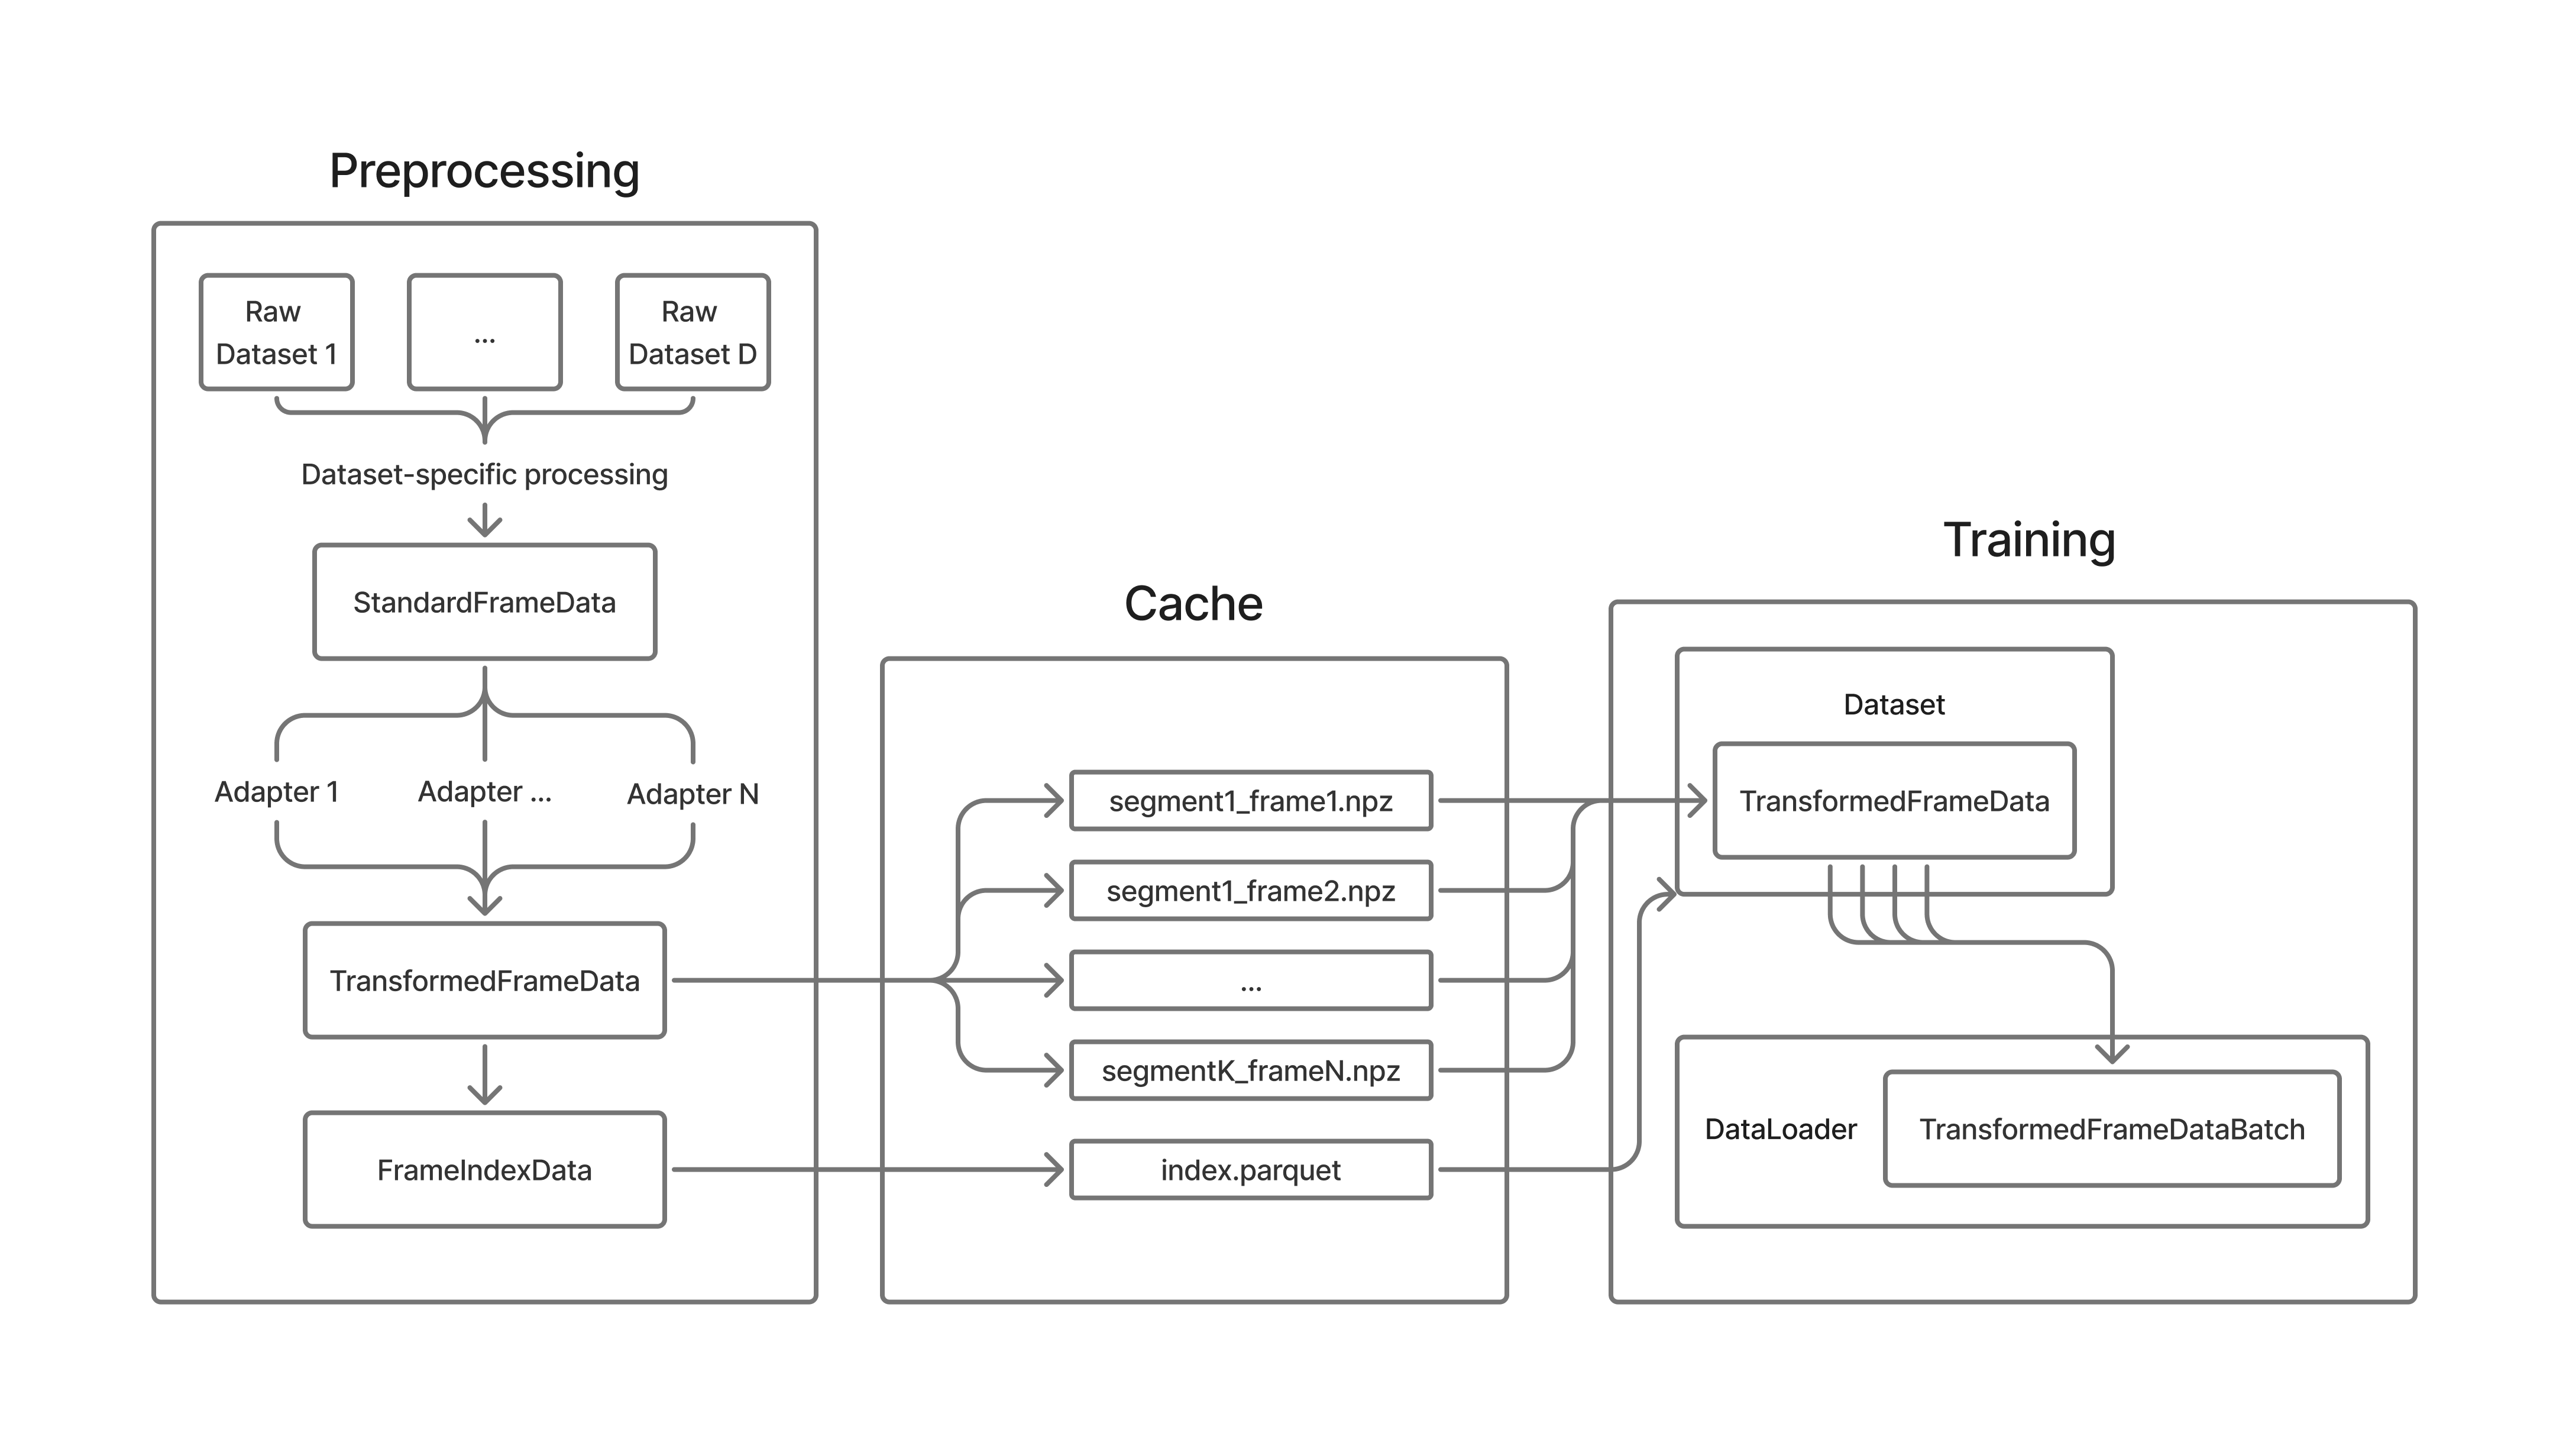

In [2]:
display.Image("../assets/standard_e2e_dataflow.png")

On a bit deeper level in preprocessing there are 2 conversions happen:

<div style="display:flex;align-items:center;gap:10px;flex-wrap:wrap;">
  <span style="border:1px solid #999;padding:6px 10px;border-radius:4px;">Raw Frame</span>

  <span style="display:inline-flex;flex-direction:column;align-items:center;line-height:1;">
    <small>dataset-specific logic</small>
    <span style="letter-spacing:6px;white-space:nowrap;">----&gt;</span>
  </span>

  <span style="border:1px solid #999;padding:6px 10px;border-radius:4px;">
    StandardFrameData
  </span>

  <span style="display:inline-flex;flex-direction:column;align-items:center;line-height:1;">
    <span style="font-size:12px;">Adapter</span>
    <span style="letter-spacing:6px;white-space:nowrap;">----&gt;</span>
  </span>

  <span style="border:1px solid #999;padding:6px 10px;border-radius:4px;">
    TransformedFrameData
  </span>
</div>

where:
* first dataset-specific logic (implemented once for a new dataset) converts the original format into a unified yet generic format kept by `StandardFrameData` (eg. for cameras data it keeps a set of original images with corresponding camera parameters)
* Adapters carry the conversion from unified `StandardFrameData` into a more specific and processing-friendly `TransformedFrameData` format (eg for cameras it can already keep the pano image after desired compression). Users may use existing adapters or freely create new ones and are welcome to contribute to repo by sharing them as same adapter can work for multiple datasets.

Preproccesing could be done via CLI:
```sh
    python -m standard_e2e.caching.process_source_dataset waymo_e2e \
        --input_path=path/to/input \
        --output_path=path/to/output \
        --split=training \
        --num_workers=32 \
        --config_file=path/to/config.yaml \
        --do_parallel_processing
```
configurable via `preprocessing` section of the config
```yaml
    preprocessing:
      adapters:
        - name: pano_adapter
          params:
            top_cut_frac: 0.0
            max_size: 384
        - name: intent_identity_adapter
        - name: future_states_identity_adapter
        - name: past_states_identity_adapter
        - name: preference_trajectory_adapter
        - name: detections_3d_identity_adapter
```

Also, there is a programmic way of preprocessing dataset:

In [ ]:
input_path = "path/to/waymo_open_dataset_end_to_end_camera_v_1_0_0"
output_path = "/path/to/output/files"
split = "val"
num_workers = 32


In [ ]:
# If processing takes too long, you may enable debug mode to speed up processing
# as it only processes the first file of the original dataset.
# However, since the frames are shuffled in the original dataset,
# processing only the first file may lead to incomplete dataset usability due to
# multiple fractures segments.

%env STANDARD_E2E_DEBUG=false

import numpy as np

from standard_e2e.caching.adapters import (
    FutureStatesIdentityAdapter,
    IntentIdentityAdapter,
    PanoImageAdapter,
    PastStatesIdentityAdapter,
    PreferenceTrajectoryAdapter,
)
from standard_e2e.caching.src_datasets.waymo_e2e import (
    WaymoE2EDatasetConverter,
    WaymoE2EDatasetProcessor,
)


processor = WaymoE2EDatasetProcessor(
    common_output_path=output_path,
    split=split,
    adapters=[
        PanoImageAdapter(max_size=384),
        IntentIdentityAdapter(),  # simply transfers intent from StandardFrameData to TransformedFrameData
        PastStatesIdentityAdapter(),
        FutureStatesIdentityAdapter(),
        PreferenceTrajectoryAdapter(),
    ],
)

converter = WaymoE2EDatasetConverter(
    source_processor=processor,
    input_path=input_path,
    split=split,
    num_workers=num_workers,
    do_parallel_processing=True,
)

converter.convert()

env: STANDARD_E2E_DEBUG=false


2025-12-24 05:35:19.161256: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Index file
Once the dataset is processed we can examine its structure. First, lets understand the idea of `index.parquet` file

In [5]:
import os
import pandas as pd

index_df = pd.read_parquet(
    os.path.join(output_path, "waymo_e2e", split, "index.parquet"))
index_df.head()

,dataset_name,segment_id,frame_id,timestamp,split,filename,extra_has_preference_trajectories,extra_intent
0,waymo_e2e,0075c28f1f1a68c4c1c8dcf37958046b,29,2.9,val,waymo_e2e/val/0075c28f1f1a68c4c1c8dcf37958046b...,False,1
1,waymo_e2e,0075c28f1f1a68c4c1c8dcf37958046b,30,3.0,val,waymo_e2e/val/0075c28f1f1a68c4c1c8dcf37958046b...,False,1
2,waymo_e2e,0075c28f1f1a68c4c1c8dcf37958046b,31,3.1,val,waymo_e2e/val/0075c28f1f1a68c4c1c8dcf37958046b...,False,1
3,waymo_e2e,0075c28f1f1a68c4c1c8dcf37958046b,32,3.2,val,waymo_e2e/val/0075c28f1f1a68c4c1c8dcf37958046b...,False,1
4,waymo_e2e,0075c28f1f1a68c4c1c8dcf37958046b,33,3.3,val,waymo_e2e/val/0075c28f1f1a68c4c1c8dcf37958046b...,False,1


here `segment_id` denotes an id for contiguous series of frames. Pair (`segment_id`, `frame_id`) denotes a unique frame. `timestamp` column allows for rapid sampling of other frames, eg. for given frame with $t=t_0$ and a given $\Delta t$ find a frame which is closest to desired $t = t_0 + \Delta t$ (more on that below). Fields called `extra_*` originate from the data passed as dictionary to `extra_index_data` param of `StandardFrameData` constructor:

```python
        standard_frame_data = StandardFrameData(
            ...
            extra_index_data={
                f"has_{PREFERENCE_TRAJECTORIES_KEY}": preference_scores_sum > 0,
                Modality.INTENT: Intent(data.intent),
            },
        )

```

### Frame file
Frame file contain preprocessed data for a given frame. Let's find one with human-labeled preference trajectory, load and examine it

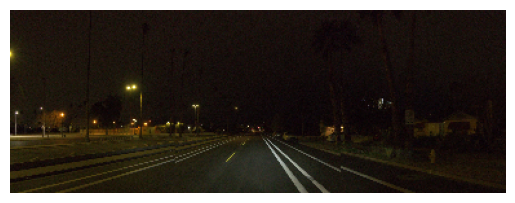

In [6]:
from matplotlib import pyplot as plt
from standard_e2e.data_structures.frame_data import TransformedFrameData
from standard_e2e.enums import Modality

# Finding the first frame with filled preference_trajectory
filtered_df = index_df[index_df["extra_has_preference_trajectories"]]
first_frame_path = filtered_df.iloc[0]["filename"]

# it is recommended to load data with TransformedFrameData.from_npz
frame_data = TransformedFrameData.from_npz(path=os.path.join(
    output_path, first_frame_path))
# get_modality_data returns the data for a specific modality
# and can also handle missing values by substituting defaults
plt.imshow(frame_data.get_modality_data(Modality.CAMERAS))
plt.axis("off")
plt.show()

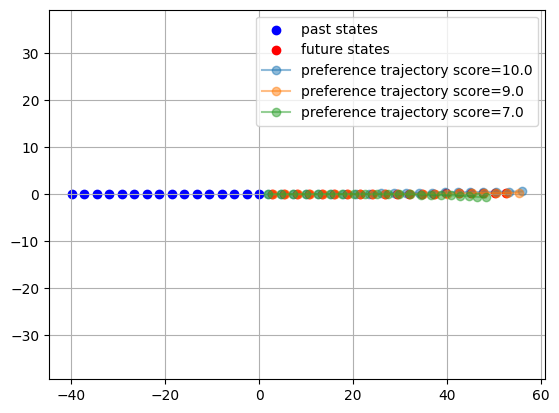

In [7]:
from standard_e2e.enums import TrajectoryComponent

XY_COMPONENTS = [TrajectoryComponent.X, TrajectoryComponent.Y]

plt.scatter(
    *frame_data.get_modality_data(Modality.PAST_STATES).get(XY_COMPONENTS).T,
    c="blue",
    label="past states",
)
plt.scatter(
    *frame_data.get_modality_data(Modality.FUTURE_STATES).get(XY_COMPONENTS).T,
    c="red",
    label="future states",
)
for preference_trajectory in frame_data.get_modality_data(
        Modality.PREFERENCE_TRAJECTORY):
    plt.plot(
        *preference_trajectory.get(XY_COMPONENTS).T,
        '-o',
        alpha=0.5,
        label=f"preference trajectory score={preference_trajectory.score}",
    )
plt.axis("equal")
plt.grid()
plt.legend()
plt.show()

# DataLoader
Once we have finished with preprocessing and understood the underlying logic we can now utilize prepared data. A key part for unified data processing is `UnifiedE2EDataset`. In order to create a `UnifiedE2EDataset` we first need to define what would be our features and labels. The easies way to understand how this logic works is by example. Let's start with a very simple example where our feature would be a pano camera image, intent and past states and we want to predict future trajectory directly.

In config it can be parametrized under the `dataset` section the following way:
```yaml
    dataset:
      features:
        - frame_name: current_sensors
          modalities:
            - cameras
            - intent
            - past_states
          selector:
            name: current
      labels:
        - frame_name: current_future_states
          modalities:
            - future_states
          selector:
            name: current
```

or programmatically:

In [8]:
from standard_e2e.dataset_utils.frame_loader import FrameLoader
from standard_e2e.dataset_utils.selector import CurrentSelector

feature_loaders = [
    FrameLoader(
        frame_name="current_sensors",
        required_modalities=[
            Modality.CAMERAS, Modality.INTENT, Modality.PAST_STATES],
        frame_selector=CurrentSelector(location="features"),
        processed_data_path=output_path,  # optional, will be set by UnifiedE2EDataset
    )]
label_loaders = [
    FrameLoader(
        frame_name="future_states",
        required_modalities=[Modality.FUTURE_STATES],
        frame_selector=CurrentSelector(location="labels"),
    )]


Also, in order to make training more stable we can interpolate trajectory states to match exact timings with `TrajectoryResampling` augmentation (optional). `MultipleFramesImageAugmentation` allows for augmentation while training and image normalization in any regime.

In [9]:
from standard_e2e.dataset_utils.augmentation import (
    MultipleFramesImageAugmentation,
    TrajectoryResampling,
)

history_time_lattice = np.linspace(-3, 0, 6, endpoint=False)
future_time_lattice = np.linspace(0, 10, 21)[1:]

trajectory_resampler_history = TrajectoryResampling(
    history_target_timestamps=history_time_lattice,
    target_frame_names=["current_sensors"],
)
trajectory_resampler_future = TrajectoryResampling(
    future_target_timestamps=future_time_lattice,
    target_frame_names=["future_states"],
)

Finally we can create `UnifiedE2EDataset` with given configurations and check its outputs:

In [10]:
from standard_e2e import UnifiedE2EDataset

dataset = UnifiedE2EDataset(
    index_data=index_df,
    processed_data_path=output_path,
    regime="val",
    feature_loaders=feature_loaders,
    label_loaders=label_loaders,
    augmentations=[
        MultipleFramesImageAugmentation("val"),
        trajectory_resampler_history,
        trajectory_resampler_future,
    ],
)

In [11]:
# Here we get a dictonaty with keys corresponding to the frame names
print(dataset[0].keys())
# and now we can check the available modalities for each of them
for k, v in dataset[0].items():
    print(f"{k} available modalities:", v.get_present_modality_keys())


dict_keys(['current_sensors', 'future_states'])
current_sensors available modalities: [<Modality.CAMERAS: 'cameras'>, <Modality.INTENT: 'intent'>, <Modality.PAST_STATES: 'past_states'>]
future_states available modalities: [<Modality.FUTURE_STATES: 'future_states'>]


Ok so now we are ready for a more advanced example. Now, for features we want to have pano image from cameras at the current timestamp $t=t_{curr}$ and also from $t=t_{curr} - 1$ and $t = t_{curr}- 2$, current intent and the past states from the current frame. For lables we will again have future trajectory, but also now (eg. in order to build a world model) we also want to have a pano image from $t = t_{curr} + 1$. Let's implement these requirements in code:

In [12]:
from standard_e2e.dataset_utils.selector import ClosestTimestampSelector

feature_loaders = [
    FrameLoader(
        frame_name="current_sensors",
        required_modalities=[
            Modality.CAMERAS, Modality.INTENT, Modality.PAST_STATES],
        frame_selector=CurrentSelector(location="features"),
    ),
    FrameLoader(
        frame_name="camera_t-1",
        required_modalities=[Modality.CAMERAS],
        frame_selector=ClosestTimestampSelector(
            location="features", delta_t=-1.0),
    ),
    FrameLoader(
        frame_name="camera_t-2",
        required_modalities=[Modality.CAMERAS],
        frame_selector=ClosestTimestampSelector(
            location="features", delta_t=-2.0),
    )]
label_loaders = [
    FrameLoader(
        frame_name="future_states",
        required_modalities=[Modality.FUTURE_STATES],
        frame_selector=CurrentSelector(location="labels"),
    ),
    FrameLoader(
        frame_name="camera_t+1",
        required_modalities=[Modality.CAMERAS],
        frame_selector=ClosestTimestampSelector(
            location="labels", delta_t=1.0),
    )]


dataset = UnifiedE2EDataset(
    index_data=index_df,
    processed_data_path=output_path,
    regime="val",
    feature_loaders=feature_loaders,
    label_loaders=label_loaders,
    augmentations=[
        # Avoiding normalization to later visualize images easily
        # Here `MultipleFramesImageAugmentation` would apply same augmentations
        # for all frames with images
        # MultipleFramesImageAugmentation("val"),
        trajectory_resampler_history,
        trajectory_resampler_future,
    ],
)

In [13]:
sample_data = dataset[99]
print(sample_data.keys())
for k, v in sample_data.items():
    print(f"{k} available modalities:", v.get_present_modality_keys())


dict_keys(['current_sensors', 'camera_t-1', 'camera_t-2', 'future_states', 'camera_t+1'])
current_sensors available modalities: [<Modality.CAMERAS: 'cameras'>, <Modality.INTENT: 'intent'>, <Modality.PAST_STATES: 'past_states'>]
camera_t-1 available modalities: [<Modality.CAMERAS: 'cameras'>]
camera_t-2 available modalities: [<Modality.CAMERAS: 'cameras'>]
future_states available modalities: [<Modality.FUTURE_STATES: 'future_states'>]
camera_t+1 available modalities: [<Modality.CAMERAS: 'cameras'>]


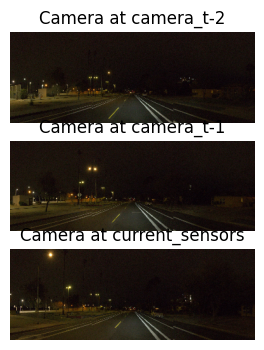

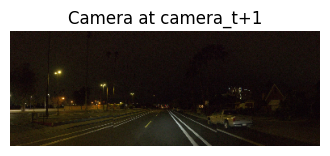

In [14]:
plt.figure(figsize=(9, 4))
for i, frame_name in enumerate(["camera_t-2", "camera_t-1", "current_sensors"], start=1):
    plt.subplot(3, 1, i)
    plt_title = f"Camera at {frame_name}"
    plt.imshow(sample_data[frame_name].get_modality_data(Modality.CAMERAS))
    plt.title(plt_title)
    plt.axis("off")
plt.show()

plt.figure(figsize=(4, 2))
plt.imshow(sample_data["camera_t+1"].get_modality_data(Modality.CAMERAS))
plt.title("Camera at camera_t+1")
plt.axis("off")
plt.show()